# Clasificador Inteligente de Rayos X

# *Fase 1: Configuración del Entorno y Datos*

# Verificación de la GPU

In [3]:


!nvidia-smi

Sat Aug  9 03:50:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Importación de Librerías Principales

In [4]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Montaje de Google Drive

In [5]:


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Descarga del Conjunto de Datos

In [6]:


!wget https://www.dropbox.com/s/73s9n7nugqrv1h7/Dataset.zip?dl=1 -O 'archive.zip'

--2025-08-09 03:50:20--  https://www.dropbox.com/s/73s9n7nugqrv1h7/Dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/z0a4ackpdc1ukixx227u6/Dataset.zip?rlkey=i250de6auumctxrrqnnqo1o10&dl=1 [following]
--2025-08-09 03:50:20--  https://www.dropbox.com/scl/fi/z0a4ackpdc1ukixx227u6/Dataset.zip?rlkey=i250de6auumctxrrqnnqo1o10&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc56044952341c56bcaf92e2a0c4.dl.dropboxusercontent.com/cd/0/inline/CvGi2_ZBZCf8TJU1G61-C98RIt37xawK5h3_bnMpiSOKVqkTD_wfS4bmVJlK3RVB41N20PT1HZfcZBijOiDu0z5L8SSDh8D4-sGvKwX0oGQNXjnltoNji9P3d7pJ8HBFrfFoyXoDbU3hyxkIOdnD9nXR/file?dl=1# [following]
--2025-08-09 03:50:21--  https://uc56044952341c56bcaf92e2a0c4.dl.dropboxusercontent.

# Descompresión y Limpieza del Dataset

In [7]:


!unzip -q '/content/archive.zip'
!rm -rf '/content/archive.zip'

# Definición de Parámetros Globales (Batch, Semilla, Rutas)

In [8]:


TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 32
SEED = 42
dataset_path = '/content/Dataset'

# Configuración del Aumento de Datos (Data Augmentation)

In [9]:


train_val_gen = ImageDataGenerator(zca_epsilon = 0.0,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True,
                                   rescale = 1./255)

test_gen = ImageDataGenerator(zca_epsilon = 0.0,
                              horizontal_flip = False,
                              rescale = 1./255)



# Creación de los Generadores de Imágenes (Train, Val, Test)

In [10]:


train_datagen = train_val_gen.flow_from_directory(directory = dataset_path + '/train',
                                                  target_size = (224, 224),
                                                  color_mode = "rgb",
                                                  classes = None,
                                                  class_mode = "categorical",
                                                  batch_size = TRAIN_BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = SEED,
                                                  interpolation = "nearest")

val_datagen = train_val_gen.flow_from_directory(directory = dataset_path + '/val',
                                                target_size = (224, 224),
                                                color_mode = "rgb",
                                                classes = None,
                                                class_mode = "categorical",
                                                batch_size = VAL_BATCH_SIZE,
                                                shuffle = True,
                                                seed = SEED,
                                                interpolation = "nearest")



test_datagen = test_gen.flow_from_directory(directory = dataset_path + '/test',
                                            target_size = (224, 224),
                                            color_mode = "rgb",
                                            classes = None,
                                            class_mode = "categorical",
                                            batch_size = 1,
                                            shuffle = False,
                                            seed = SEED,
                                            interpolation = "nearest")

Found 11290 images belonging to 3 classes.
Found 3215 images belonging to 3 classes.
Found 1563 images belonging to 3 classes.


# *Fase 2: Construcción y Entrenamiento del Modelo*

# Carga del Modelo Base (DenseNet121) y Adición de Capas Personalizadas

In [11]:

base_model = tf.keras.applications.DenseNet121(weights = 'imagenet',
                                                   include_top = False,
                                                   input_shape = (224, 224, 3),
                                                   pooling = 'max')


base_model.trainable = True


x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Resumen de la Arquitectura del Modelo Base

In [12]:


print(base_model.summary())

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

None


# Compilación del Modelo (Optimizador y Función de Pérdida)

In [13]:


model.compile(optimizer = tf.keras.optimizers.Adam(1e-5),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

# Definición de Callbacks para el Entrenamiento

In [14]:
import tensorflow as tf


model_filepath = '/content/drive/MyDrive/best_model.keras'




model_save = tf.keras.callbacks.ModelCheckpoint(model_filepath,
                                                monitor = "val_accuracy",
                                                verbose = 1,
                                                save_best_only = True,
                                                save_weights_only = False,
                                                mode = "max",
                                                save_freq = "epoch")


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')




callback = [model_save, reduce_lr]

# Inicio del Entrenamiento del Modelo

In [15]:

history = model.fit(train_datagen,
                    epochs = 10,
                    steps_per_epoch = (len(train_datagen)),
                    validation_data = val_datagen,
                    validation_steps = (len(val_datagen)),
                    shuffle = False,
                    callbacks = callback)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4769 - loss: 1.2127
Epoch 1: val_accuracy improved from -inf to 0.40218, saving model to /content/drive/MyDrive/best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 644s 5s/step - accuracy: 0.4780 - loss: 1.2099 - val_accuracy: 0.4022 - val_loss: 1.8649 - learning_rate: 1.0000e-05
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7662 - loss: 0.5529
Epoch 2: val_accuracy improved from 0.40218 to 0.54899, saving model to /content/drive/MyDrive/best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.7665 - loss: 0.5524 - val_accuracy: 0.5490 - val_loss: 1.0528 - learning_rate: 1.0000e-05
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8488 - loss: 0.3827
Epoch 3: val_accuracy improved from 0.54899 to 0.70669, saving model to /content/drive/MyDrive/best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8488 - loss: 0.3826 - val_accuracy: 0.7067 - val_loss: 0.7444 - learning_rat

# Verificación de Montaje de Google Drive

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Resumen del Modelo Completo (Incluyendo Capas de Clasificación)

In [17]:
# Printing the model summary

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 21,348,171 (81.44 MB)

 Trainable params: 7,087,491 (27.04 MB)

 Non-trainable params: 85,696 (334.75 KB)

 Optimizer params: 14,174,984 (54.07 MB)

None


# *Fase 3: Evaluación del Modelo y Visualización*

# Verificación de Lotes en el Generador de Validación

In [18]:
len(val_datagen)

101

# Gráficas de Pérdida y Precisión (Entrenamiento vs. Validación)

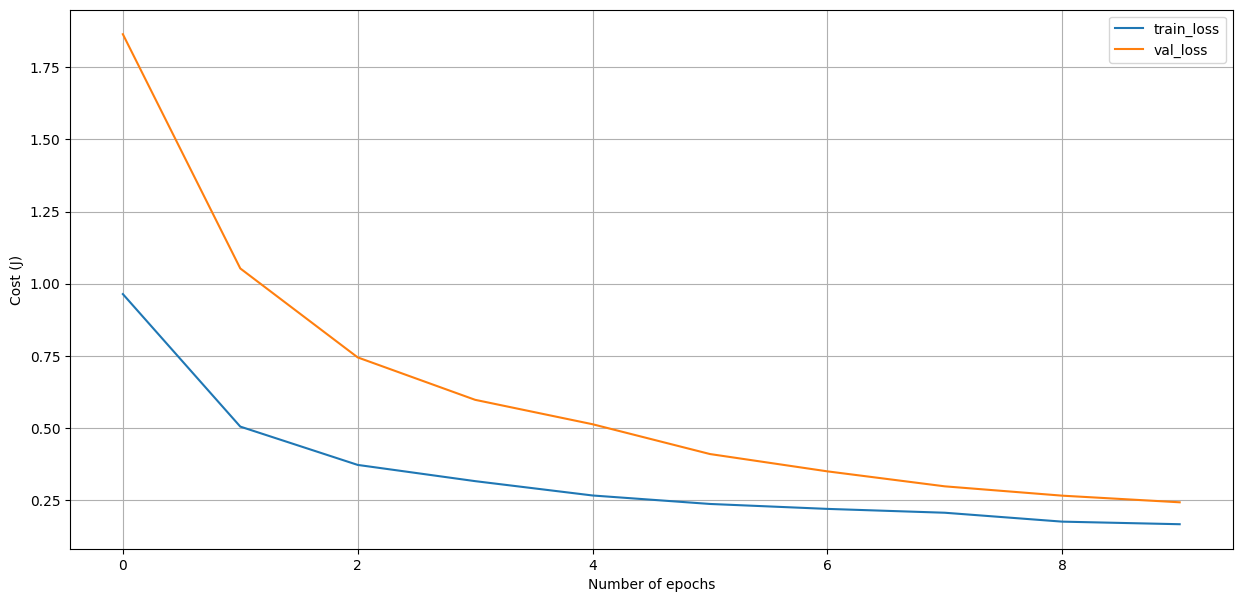

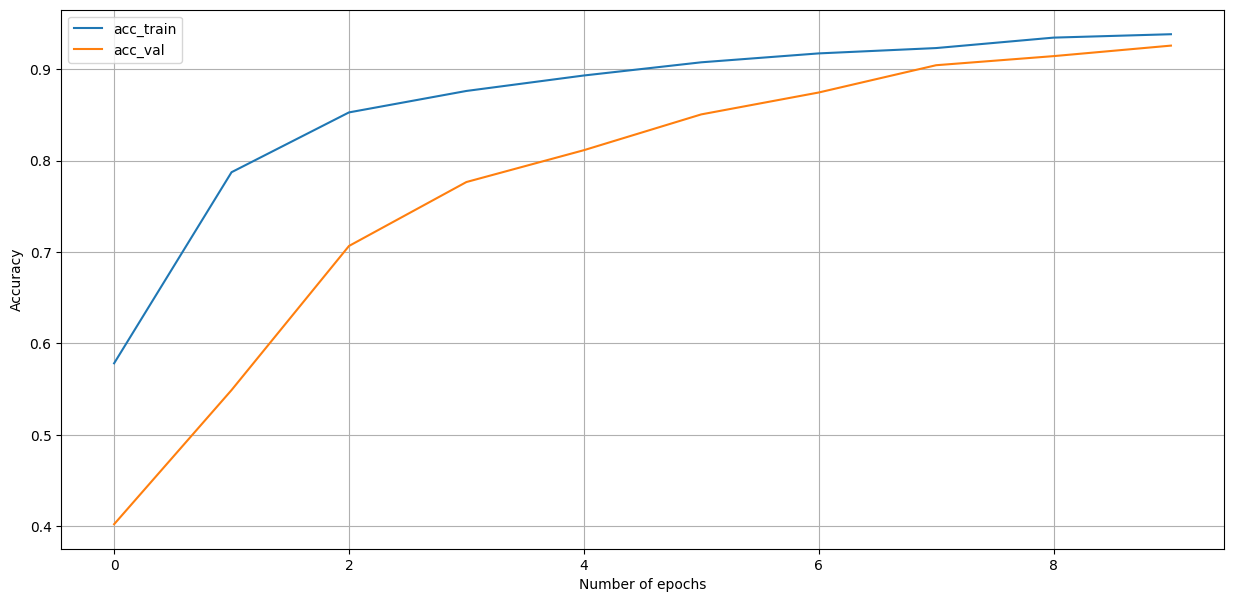

In [19]:
# Plotting the loss and accuracy graphs

import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

tr_losses = history.history['loss']
val_losses = history.history['val_loss']

tr_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

plt.plot(tr_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (15,7))

plt.plot(tr_accs, label = "acc_train")
plt.plot(val_accs, label = "acc_val")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

# Realización de Predicciones en el Conjunto de Prueba

In [20]:


predictions = model.predict(test_datagen,
                            verbose = 1,
                            steps = (len(test_datagen)))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step


# Visualización de las Clases Predichas (Formato Numérico)

In [21]:


predictions.squeeze().argmax(axis = -1)

array([0, 0, 0, ..., 2, 2, 2])

# Generación del Reporte de Clasificación (Métricas Detalladas)

In [22]:


classification__report = classification_report(test_datagen.classes,
                                               predictions.squeeze().argmax(axis = 1))
print(classification__report)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       491
           1       0.84      0.97      0.90       545
           2       0.99      0.93      0.96       527

    accuracy                           0.92      1563
   macro avg       0.93      0.92      0.92      1563
weighted avg       0.93      0.92      0.92      1563



# Cálculo de la Matriz de Confusión

In [23]:


confusion__matrix = confusion_matrix(test_datagen.classes,
                                     predictions.squeeze().argmax(axis = 1))
print(confusion__matrix)

[[424  65   2]
 [ 16 527   2]
 [  2  35 490]]


# Definición de la Función para Graficar la Matriz de Confusión

In [24]:


import itertools
def plot_confusion_matrix(cm,
                          classes,
                          normalise = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Reds):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = cm.round(2)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualización de la Matriz de Confusión (Sin Normalizar)

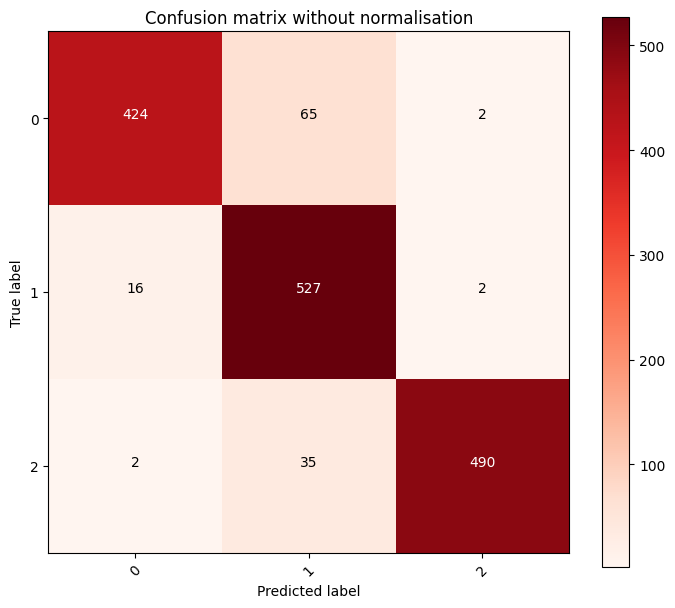

In [25]:


np.set_printoptions(precision = 2)
fig1 = plt.figure(figsize = (7, 6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(test_datagen.classes),
                      title = 'Confusion matrix without normalisation')
fig1.savefig('/content/cm_wo_norm.jpg')
plt.show()

# Visualización de la Matriz de Confusión (Normalizada)

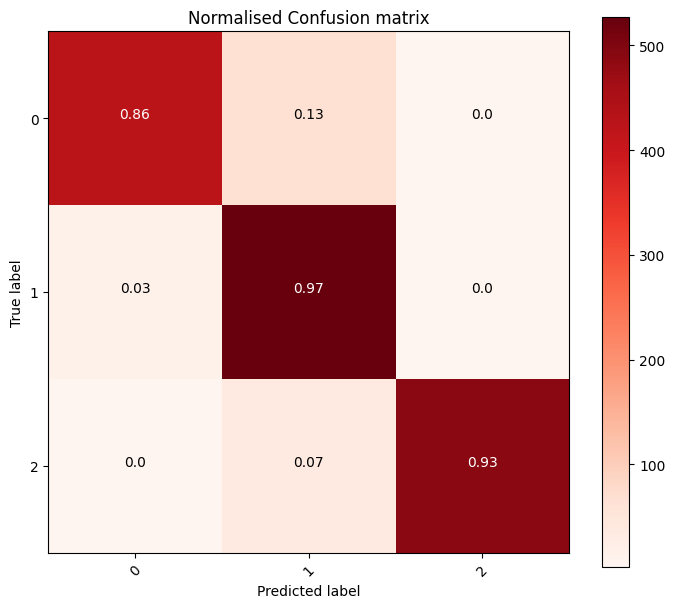

In [26]:


np.set_printoptions(precision = 2)
fig2 = plt.figure(figsize = (7,6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(test_datagen.classes),
                      normalise = True,
                      title = 'Normalised Confusion matrix')
fig2.savefig('/content/cm_norm.jpg')
plt.show()



# *Fase 4: Despliegue de la Interfaz*

In [ ]:

!pip install -q gradio

import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

model_path = '/content/drive/MyDrive/best_model.keras'


if not os.path.exists(model_path):
    print(f"Error: Archivo del modelo no encontrado en {model_path}")
    print("Por favor, asegúrate de haber entrenado y guardado el modelo en la celda anterior.")
else:
    model_to_deploy = tf.keras.models.load_model(model_path)


    dataset_path = '/content/Dataset'
    IMAGE_SIZE = (224, 224)
    test_gen = ImageDataGenerator(rescale=1./255)
    test_datagen = test_gen.flow_from_directory(
        directory=os.path.join(dataset_path, 'test'),
        target_size=IMAGE_SIZE,
        class_mode="categorical",
        batch_size=1,
        shuffle=False
    )
    labels = list(test_datagen.class_indices.keys())



    def predict_and_explain(input_image):
        if input_image is None:
            return None, "Por favor, sube una imagen primero."

        image = np.array(input_image)
        image = tf.image.resize(image, (224, 224))
        image = image / 255.0
        image = np.expand_dims(image, axis=0)
        prediction = model_to_deploy.predict(image)
        confidences = {labels[i]: float(prediction[0][i]) for i in range(len(labels))}
        predicted_class = labels[np.argmax(prediction)]
        confidence_score = np.max(prediction)

        explanation = (
            f"Predicción: *{predicted_class}* con una confianza de *{confidence_score:.2%}*.\n\n"
            f"*Este es un resultado de un modelo de IA. "
            f"Buscar siempre la validación de un profesional de la salud.*"
        )

        return confidences, explanation


    custom_css = """
    body { background-color: #f0f2f6; }
    .gradio-container { border-radius: 20px !important; }
    #title { color: #1d3557; text-align: center; font-family: 'Arial Black', sans-serif; }
    #description { color: #457b9d; text-align: center; font-size: 1.1em; }
    .gradio-image { border: 2px solid #a8dadc; border-radius: 10px; }
    .gradio-label { background-color: #e9c46a !important; border-radius: 10px !important; }
    """


    article_text = """
    ## Sobre este Proyecto
    Este proyecto fue desarrollado como una herramienta de apoyo para la clasificación de radiografías de tórax.
    ### Modelo Utilizado
    Se utilizó una red neuronal convolucional basada en la arquitectura *DenseNet121* con aprendizaje por transferencia, entrenada en un conjunto de datos público que contiene imágenes de:
    - *COVID-19*
    - *Neumonía*
    - *Pulmones Normales*
    ### Limitaciones
    Este modelo es una demostración académica y *no debe ser utilizado para autodiagnóstico*. Siempre consulte a un profesional de la salud.
    """


    with gr.Blocks(theme=gr.themes.Soft(), css=custom_css) as demo:
        gr.Markdown("# Clasificador Inteligente de Rayos X ", elem_id="title")
        gr.Markdown("Sube una radiografía para que el modelo la clasifique como COVID-19, Neumonía o Normal.", elem_id="description")

        with gr.Row():
            image_input = gr.Image(type="pil", label="Sube tu imagen aquí")
            with gr.Column():
                label_output = gr.Label(num_top_classes=3, label="Resultado de la Predicción")
                textbox_output = gr.Textbox(label="Interpretación")

        predict_button = gr.Button("Clasificar Imagen")
        predict_button.click(fn=predict_and_explain, inputs=image_input, outputs=[label_output, textbox_output])

        gr.Examples(
            examples=[
                os.path.join(dataset_path, 'test/covid/168.jpeg'),
                os.path.join(dataset_path, 'test/normal/00000002_000.png'),
                os.path.join(dataset_path, 'test/pneumonia/00000165_001.png')
            ],
            inputs=image_input
        )

        gr.Markdown(article_text)


    demo.launch(debug=True)

Found 1563 images belonging to 3 classes.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://267f1ba92d9b72eed4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
